<a href="https://colab.research.google.com/github/lili0706/final_project/blob/main/DL_finalPJ_using_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from keras.metrics import binary_accuracy
from tensorflow.keras.metrics import BinaryAccuracy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, hamming_loss, roc_curve
from sklearn.metrics import auc as sklearn_auc

In [ ]:
# 載入數據
drugs_info = pd.read_csv('drugsInfo.csv')
mapping = pd.read_csv('mapping.csv')
diseases_info = pd.read_csv('diseasesInfo.csv')

# 篩選包含 "Cancer" 字樣的疾病
cancer_diseases = diseases_info[diseases_info['SlimMapping'].str.contains('Cancer', na=False)]
cancer_disease_ids = cancer_diseases['DiseaseID'].unique()
display(cancer_diseases.head(5))
print(cancer_disease_ids[:5])


,DiseaseID,DiseaseName,DiseaseDescription,SlimMapping,PathwayNames
1,MESH:D058739,Aberrant Crypt Foci,Clusters of colonic crypts that appear differe...,['Cancer'],Wnt signaling pathway
21,MESH:D000230,Adenocarcinoma,A malignant epithelial tumor with a glandular ...,['Cancer'],ZBP1(DAI) mediated induction of type I IFNs
22,MESH:D018262,"Adenocarcinoma, Clear Cell",An adenocarcinoma characterized by the presenc...,['Cancer'],Wnt signaling pathway
23,MESH:D018263,"Adenocarcinoma, Follicular","An adenocarcinoma of the thyroid gland, in whi...",['Cancer'],Viral carcinogenesis
24,MESH:D000077192,Adenocarcinoma of Lung,A carcinoma originating in the lung and the mo...,['Cancer'],YAP1- and WWTR1 (TAZ)-stimulated gene expression


['MESH:D058739' 'MESH:D000230' 'MESH:D018262' 'MESH:D018263'
 'MESH:D000077192']


In [ ]:
# 找出癌症相關疾病對應的藥物:在mapping中找到DiseaseID對應的DrugID
cancer_drug_mapping = mapping[mapping['DiseaseID'].isin(cancer_disease_ids)]
cancer_drug_ids = cancer_drug_mapping['DrugID'].unique()
display(cancer_drug_mapping.head())
print(cancer_drug_ids[:5])

,DrugID,DiseaseID
174,DB05294,MESH:D000077192
175,DB00571,MESH:D000077192
176,DB00361,MESH:D000077192
177,DB01169,MESH:D000077192
178,DB08865,MESH:D000077192


['DB05294' 'DB00571' 'DB00361' 'DB01169' 'DB08865']


In [ ]:
# 準備標籤矩陣:DiseaseID有對應DrugID的設為1
labels = {}
for drug_id in cancer_drug_ids:
    related_diseases = cancer_drug_mapping[cancer_drug_mapping['DrugID'] == drug_id]['DiseaseID']
    for disease_id in related_diseases:
        if disease_id not in labels:
            labels[disease_id] = []
        labels[disease_id].append(drug_id)

num_diseases = len(cancer_disease_ids)
num_drugs = len(cancer_drug_ids)

label_matrix = np.zeros((num_diseases, num_drugs))
disease_to_idx = {disease_id: idx for idx, disease_id in enumerate(cancer_disease_ids)}
drug_to_idx = {drug_id: idx for idx, drug_id in enumerate(cancer_drug_ids)}

for disease_id, drug_ids in labels.items():
    disease_idx = disease_to_idx[disease_id]
    for drug_id in drug_ids:
        drug_idx = drug_to_idx[drug_id]
        label_matrix[disease_idx, drug_idx] = 1


In [ ]:
# 將疾病描述轉換為數值特徵
vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]+\b', max_features=100, stop_words='english')
input_disease_data = vectorizer.fit_transform(cancer_diseases['DiseaseDescription']).toarray()
feature_names_disease = vectorizer.get_feature_names_out()
print("Top10 疾病特徵名稱:", feature_names_disease[:10])

# 將藥物描述轉換為數值特徵
drug_vectorizer = TfidfVectorizer(token_pattern=r'\b[a-zA-Z]+\b', max_features=100, stop_words='english')
input_drug_data = drug_vectorizer.fit_transform(drugs_info['DrugDescription']).toarray()
feature_names_drug = drug_vectorizer.get_feature_names_out()
print("\nTop10 藥物特徵名稱:", feature_names_drug[:10])

# 對每個疾病將相關藥物的特徵組合在一起
input_combined_data = np.zeros((num_diseases, input_disease_data.shape[1] + input_drug_data.shape[1]))

for disease_idx, disease_id in enumerate(cancer_disease_ids):
    # 添加疾病特徵
    input_combined_data[disease_idx, :input_disease_data.shape[1]] = input_disease_data[disease_idx]

    # 添加該疾病相關的藥物特徵
    for drug_idx in range(num_drugs):
        if label_matrix[disease_idx, drug_idx] == 1:
            # 使用相關藥物的完整特徵向量，而不是簡單的標記
            input_combined_data[disease_idx, input_disease_data.shape[1]:] += input_drug_data[drug_idx]

print("\n標籤矩陣:",np.shape(label_matrix))

# 將特徵輸出為 CSV 文件
np.savetxt("disease_features.csv", input_disease_data, delimiter=",", header=",".join(vectorizer.get_feature_names_out()), comments="")
np.savetxt("drug_features.csv", input_drug_data, delimiter=",", header=",".join(drug_vectorizer.get_feature_names_out()), comments="")

# 檢查 input_combined_data 的形狀
print("\n結合特徵矩陣",input_combined_data.shape)  # 確保列數是疾病特徵數量 + 藥物數量


header = ",".join(feature_names_disease) + "," + ",".join(feature_names_drug)


np.savetxt("combined_features.csv", input_combined_data, delimiter=",", header=header, comments="")

Top10 疾病特徵名稱: ['abnormal' 'adenocarcinoma' 'adults' 'al' 'anaplastic' 'arise' 'arising'
 'associated' 'b' 'benign']

Top10 藥物特徵名稱: ['acid' 'acidis' 'acting' 'activity' 'acute' 'adjunct' 'adrenergic'
 'agent' 'agonist' 'allergic']

標籤矩陣: (240, 477)

結合特徵矩陣 (240, 200)


In [ ]:
# 訓練/測試資料分割
X_train, X_test, y_train, y_test = train_test_split(input_combined_data, label_matrix, test_size=0.2, random_state=42)

# 建立FNN模型
input_combined = layers.Input(shape=(X_train.shape[1],))
x = layers.Dense(128, activation='relu')(input_combined)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_drugs = layers.Dense(num_drugs, activation='sigmoid')(x)

model = models.Model(inputs=input_combined, outputs=output_drugs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# 訓練模型
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)



Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 790ms/step - binary_accuracy: 0.5145 - loss: 0.6989 - val_binary_accuracy: 0.6576 - val_loss: 0.6797
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.6246 - loss: 0.6788 - val_binary_accuracy: 0.7955 - val_loss: 0.6585
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.7239 - loss: 0.6547 - val_binary_accuracy: 0.8815 - val_loss: 0.6171
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8071 - loss: 0.6193 - val_binary_accuracy: 0.9282 - val_loss: 0.5538
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.8743 - loss: 0.5685 - val_binary_accuracy: 0.9538 - val_loss: 0.4798
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.9197 - loss: 0.5083 - val_binary_accuracy: 0.9600 - val_loss: 0.4174
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9486 - loss: 0.4368 - val_binary_accuracy: 0.9622 - val_loss: 0.3798
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━

In [ ]:
# 在測試集上評估模型
y_pred = model.predict(X_test)

# 檢查預測值分布
print("Prediction distribution:")
print(f"Min: {y_pred.min()}, Max: {y_pred.max()}, Mean: {y_pred.mean()}")

# 使用固定閾值將預測值轉換為二進制格式
threshold = 0.1
y_pred_bin = (y_pred > threshold).astype(int)

# 計算評估指標
f1 = f1_score(y_test, y_pred_bin, average='samples')
precision = precision_score(y_test, y_pred_bin, average='samples')
recall = recall_score(y_test, y_pred_bin, average='samples')
hamming = hamming_loss(y_test, y_pred_bin)

# 使用 Binary Accuracy
binary_acc = BinaryAccuracy()
binary_acc.update_state(y_test, y_pred_bin)
accuracy = binary_acc.result().numpy()

print("\n模型評估指標:")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Hamming Loss: {hamming:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# 計算 AUC
auc = roc_auc_score(y_test, y_pred, average='samples')
print(f"AUC: {auc:.4f}\n")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Prediction distribution:
Min: 9.710310223454144e-06, Max: 0.5088717341423035, Mean: 0.030170219019055367

模型評估指標:
F1 Score: 0.2342
Precision: 0.2652
Recall: 0.3887
Hamming Loss: 0.0767
Accuracy: 0.9233
AUC: 0.8071



Macro-Averaged AUC (excluding single-class drugs): 0.6717
Micro-Averaged AUC: 0.8065


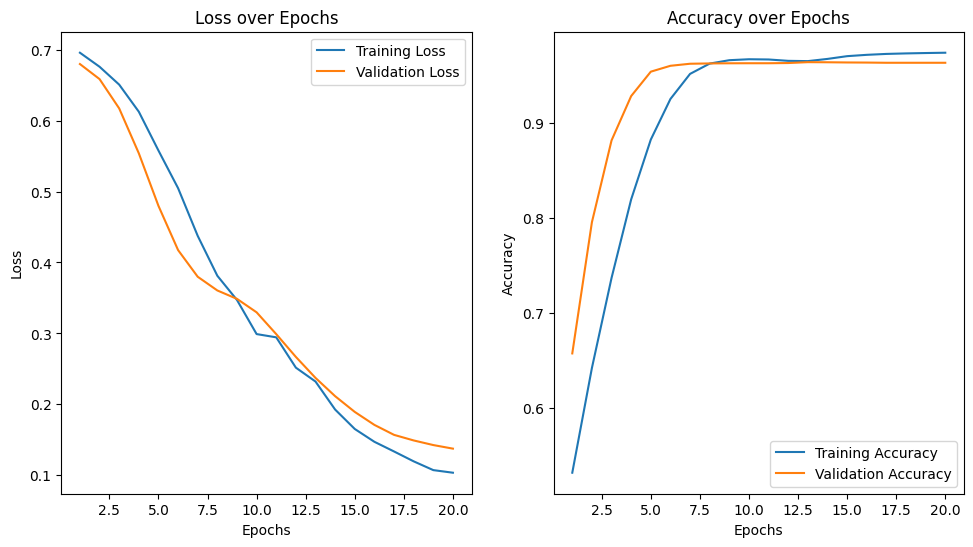

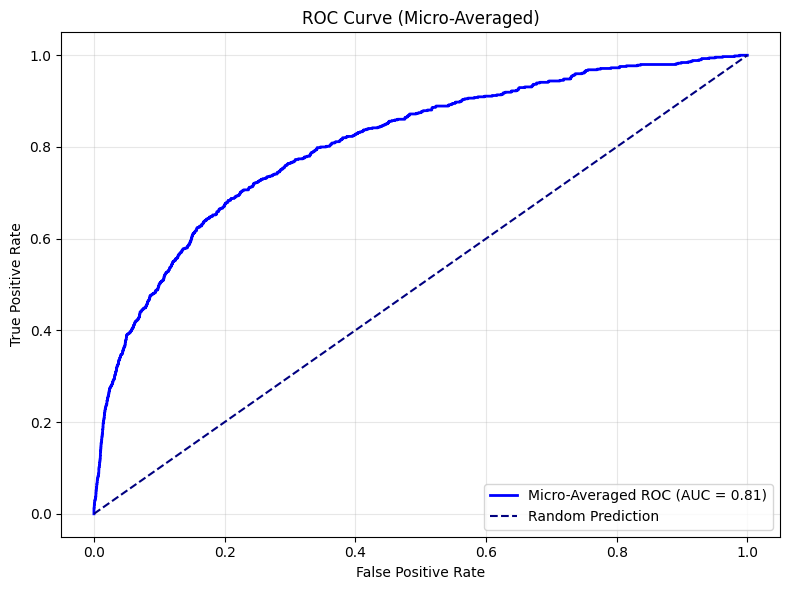

In [ ]:
# 繪製評估指標圖表
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(18, 6))

# 繪製 Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 繪製 Binary Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 計算宏平均 AUC，忽略單一類別的藥物(每個疾病只與這個藥物相關，或者這個藥物只對一個疾病有效的藥物)
valid_aucs = []
for i in range(num_drugs):
    if len(np.unique(y_test[:, i])) > 1:  # 至少有一個正例和一個負例
        auc_value = roc_auc_score(y_test[:, i], y_pred[:, i])
        valid_aucs.append(auc_value)

auc_macro = np.mean(valid_aucs) if valid_aucs else 0.0
print(f"Macro-Averaged AUC (excluding single-class drugs): {auc_macro:.4f}")

# 繪製微平均 ROC 曲線
fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_pred.ravel())
auc_micro = sklearn_auc(fpr_micro, tpr_micro)
print(f"Micro-Averaged AUC: {auc_micro:.4f}")

# 繪製 ROC 曲線圖
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-Averaged ROC (AUC = {auc_micro:.2f})', color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Prediction')
plt.title('ROC Curve (Micro-Averaged)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
